In [1]:
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import gc
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer
import re
from lightgbm import LGBMClassifier as lgbc
from catboost import CatBoostClassifier as cbc
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold, GridSearchCV
import scipy.sparse as scp

In [2]:
path = Path('D:\Загрузки, торрент\Kaggle\Home')

In [3]:
app_train = pd.read_csv(Path(path /'application_train.csv'));
app_test = pd.read_csv(Path(path /'application_test.csv'));

In [4]:
print(app_train.append(app_test).shape)

(356255, 122)


In [5]:
app_test['CODE_GENDER'].unique()

array(['F', 'M'], dtype=object)

In [6]:
df = app_train.append(app_test).reset_index()
df = df[df['CODE_GENDER'] != 'XNA']

In [7]:
docs = [_f for _f in df.columns if 'FLAG_DOC' in _f];
line = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]

In [8]:
inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']

In [3]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na = nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(Path(path /'application_train.csv'), nrows= num_rows)
    test_df = pd.read_csv(Path(path /'application_test.csv'), nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()#добавляют столбец индекса 
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
    live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)#заменяет nan на число, количество дней, которые отработал клиент до кредита
    inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']#группирует типы организаций, где работает
    #клиент на медианное значение дохода клиента в зависимости от организации

    df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']#разделяет сумму кредита клиента на анниенту
    df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']#разделяет сумму кредита клиента на цену товара, если это потрбительский кредит
    df['NEW_DOC_IND_AVG'] = df[docs].mean(axis=1)
    df['NEW_DOC_IND_STD'] = df[docs].std(axis=1)
    df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)#находит коэффициент эксцесса
    df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
    df['NEW_LIVE_IND_STD'] = df[live].std(axis=1)
    df['NEW_LIVE_IND_KURT'] = df[live].kurtosis(axis=1)
    df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])#разделяет доход клиента на число детей + 1
    df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)#новый признак по значению inc_by_org 
    df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']#количество дней от подачи заявления на кредит делится на число дней со дня рождения
    df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])#ежемесячный платеж на доход клиента
    df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']#перемножение внешних данных
    df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)#усредненное значение по столбцам
    df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
    df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['NEW_PHONE_TO_EMPLOY_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
    df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']#отношение суммы кредита к доходу клиента
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    del test_df
    gc.collect()#очищает память в python
    return df

In [11]:
app = app_train.append(app_test).reset_index()

In [4]:
data = application_train_test()

Train samples: 307511, test samples: 48744


In [50]:
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(Path(path /'bureau.csv'), nrows = num_rows)#данные по предыдущим займам в других кредитных организациях
    bb = pd.read_csv(Path(path /'bureau_balance.csv'), nrows = num_rows)#ежемесячные данные по предыдущим кредитам по бюро
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)#ohe с кодированием nan, как категории 
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']#создает словарь для того, чтобы затем пройтись по колонком и найти средние значения
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations);#группирует по ID, затем ищет заданные значения по колонкам
    bb_agg.columns = pd.Index([e[0] + '_' + e[1].upper() for e in bb_agg.columns]);
    bureau = bureau.join(bb_agg, how = 'left', on = 'SK_ID_BUREAU');#присоединяет burea с bb_agg по SK_ID
    bureau.drop('SK_ID_BUREAU', axis = 1, inplace = True);
    del bb, bb_agg
    gc.collect()
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})#создает новые колонки bureau по текущим ID 
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])#новые имена для колонок
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]#берет только активные кредиты для данного клиента
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)#считает для них численные признаки
    cols = active_agg.columns.tolist()
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]#берет только закрытые кредиты для данного клиента
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    
    for e in cols:
        bureau_agg['NEW_RATIO_BURO_' + e[0] + "_" + e[1].upper()] = bureau_agg['ACTIVE_' + e[0] + "_" + e[1].upper()] / bureau_agg['CLOSED_' + e[0] + "_" + e[1].upper()]
    
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [15]:
bb = pd.read_csv(Path(path /'bureau_balance.csv'))
bb, bb_cat = one_hot_encoder(bb, True)
bureau = pd.read_csv(Path(path /'bureau.csv'))
bureau, bureau_cat = one_hot_encoder(bureau, True)

In [29]:
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in bb_cat:
    bb_aggregations[col] = ['mean'];
bb_agg = bb.groupby(['SK_ID_BUREAU']).agg(bb_aggregations);
bb_agg.columns = [a[0] + '_' + a[1].upper() for a in bb_agg.columns];
burea_agg = bureau.join(bb_agg, how = 'left', on = 'SK_ID_BUREAU')

In [51]:
bureau_agg = bureau_and_balance()

In [87]:
bureau_agg

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,...,NEW_RATIO_BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,NEW_RATIO_BURO_AMT_CREDIT_SUM_LIMIT_MEAN,NEW_RATIO_BURO_AMT_CREDIT_SUM_LIMIT_SUM,NEW_RATIO_BURO_AMT_ANNUITY_MAX,NEW_RATIO_BURO_AMT_ANNUITY_MEAN,NEW_RATIO_BURO_CNT_CREDIT_PROLONG_SUM,NEW_RATIO_BURO_MONTHS_BALANCE_MIN_MIN,NEW_RATIO_BURO_MONTHS_BALANCE_MAX_MAX,NEW_RATIO_BURO_MONTHS_BALANCE_SIZE_MEAN,NEW_RATIO_BURO_MONTHS_BALANCE_SIZE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,...,NaN,NaN,NaN,inf,inf,NaN,0.352941,NaN,0.304762,0.228571
100002,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,-499.875000,0,0.0,...,NaN,inf,inf,NaN,NaN,NaN,0.723404,NaN,0.666667,0.222222
100003,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,0,0.0,...,NaN,inf,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,-532.000000,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,-54.333333,0,0.0,...,NaN,NaN,NaN,inf,inf,NaN,0.333333,NaN,0.307692,0.615385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456249,-2713,-483,-1667.076923,407302.243590,-2499.0,1363.0,-1232.333333,-1064.538462,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456250,-1002,-760,-862.000000,15724.000000,-272.0,2340.0,1288.333333,-60.333333,0,0.0,...,NaN,inf,inf,0.134843,0.10355,NaN,0.843750,NaN,0.818182,1.636364
456253,-919,-713,-867.500000,10609.000000,-189.0,1113.0,280.500000,-253.250000,0,0.0,...,NaN,NaN,NaN,1.000000,1.00000,NaN,1.000000,NaN,0.887097,0.887097


In [64]:
def previous_applications(num_rows = None, nan_as_category = True):#данные по предыдущим заявкам в Home_Kredit
    prev = pd.read_csv(Path(path / 'previous_application.csv'), nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']#отношение запрошенной суммы относительно суммы, которую дал банк клиенту
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]#подтвержденная заявка в течение месяца 
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    cols = approved_agg.columns.tolist()
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]#не подтвержденная заявка в течение месяца 
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    
    for e in cols:
        prev_agg['NEW_RATIO_PREV_' + e[0] + "_" + e[1].upper()] = prev_agg['APPROVED_' + e[0] + "_" + e[1].upper()] / prev_agg['REFUSED_' + e[0] + "_" + e[1].upper()]
    
    gc.collect()
    return prev_agg


In [65]:
prev_agg = previous_applications()

In [85]:
prev_agg

,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_APP_CREDIT_PERC_MIN,...,NEW_RATIO_PREV_HOUR_APPR_PROCESS_START_MAX,NEW_RATIO_PREV_HOUR_APPR_PROCESS_START_MEAN,NEW_RATIO_PREV_RATE_DOWN_PAYMENT_MIN,NEW_RATIO_PREV_RATE_DOWN_PAYMENT_MAX,NEW_RATIO_PREV_RATE_DOWN_PAYMENT_MEAN,NEW_RATIO_PREV_DAYS_DECISION_MIN,NEW_RATIO_PREV_DAYS_DECISION_MAX,NEW_RATIO_PREV_DAYS_DECISION_MEAN,NEW_RATIO_PREV_CNT_PAYMENT_MEAN,NEW_RATIO_PREV_CNT_PAYMENT_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3951.000,3951.000,3951.000000,24835.5,24835.5,24835.500,23787.0,23787.0,23787.00,1.044079,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100002,9251.775,9251.775,9251.775000,179055.0,179055.0,179055.000,179055.0,179055.0,179055.00,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,6737.310,98356.995,56553.990000,68809.5,900000.0,435436.500,68053.5,1035882.0,484191.00,0.868825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,5357.250,5357.250,5357.250000,24282.0,24282.0,24282.000,20106.0,20106.0,20106.00,1.207699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,4813.200,4813.200,4813.200000,0.0,44617.5,22308.750,0.0,40153.5,20076.75,1.111173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,6605.910,6605.910,6605.910000,40455.0,40455.0,40455.000,40455.0,40455.0,40455.00,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456252,10074.465,10074.465,10074.465000,57595.5,57595.5,57595.500,56821.5,56821.5,56821.50,1.013622,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456253,3973.095,5567.715,4770.405000,19413.0,28912.5,24162.750,13945.5,27306.0,20625.75,1.058833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
def pos_cash(num_rows = None, nan_as_category = True):#Ежемесячные данные по кредитам в Home Creditс выдачей наличными и кредитам на покупки товаров
    pos = pd.read_csv(Path(path / 'POS_CASH_balance.csv'));
    pos, pos_cat = one_hot_encoder(pos, True);
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in pos_cat: aggregations[cat] = ['mean'];
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations);
    pos_agg.columns = pd.Index([i[0] + '_' + i[1].upper() for i in pos_agg.columns])
    #pos = pos.join(pos_agg, how = 'left', on = 'SK_ID_CURR')#соединяет по тем слобцам, которые есть в правой части - SK_ID_CURR
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size();
    del pos
    gc.collect
    return pos_agg

In [67]:
pos = pos_cash()

In [84]:
pos

,MONTHS_BALANCE_MAX,MONTHS_BALANCE_MEAN,MONTHS_BALANCE_SIZE,SK_DPD_MAX,SK_DPD_MEAN,SK_DPD_DEF_MAX,SK_DPD_DEF_MEAN,NAME_CONTRACT_STATUS_Active_MEAN,NAME_CONTRACT_STATUS_Amortized debt_MEAN,NAME_CONTRACT_STATUS_Approved_MEAN,NAME_CONTRACT_STATUS_Canceled_MEAN,NAME_CONTRACT_STATUS_Completed_MEAN,NAME_CONTRACT_STATUS_Demand_MEAN,NAME_CONTRACT_STATUS_Returned to the store_MEAN,NAME_CONTRACT_STATUS_Signed_MEAN,NAME_CONTRACT_STATUS_XNA_MEAN,NAME_CONTRACT_STATUS_nan_MEAN,POS_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,
100001,-53,-72.555556,9,7,0.777778,7,0.777778,0.777778,0.0,0.0,0.0,0.222222,0.0,0.0,0.000000,0.0,0,9
100002,-1,-10.000000,19,0,0.000000,0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0,19
100003,-18,-43.785714,28,0,0.000000,0,0.000000,0.928571,0.0,0.0,0.0,0.071429,0.0,0.0,0.000000,0.0,0,28
100004,-24,-25.500000,4,0,0.000000,0,0.000000,0.750000,0.0,0.0,0.0,0.250000,0.0,0.0,0.000000,0.0,0,4
100005,-15,-20.000000,11,0,0.000000,0,0.000000,0.818182,0.0,0.0,0.0,0.090909,0.0,0.0,0.090909,0.0,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,-1,-5.000000,9,0,0.000000,0,0.000000,0.777778,0.0,0.0,0.0,0.111111,0.0,0.0,0.111111,0.0,0,9
456252,-76,-79.000000,7,0,0.000000,0,0.000000,0.857143,0.0,0.0,0.0,0.142857,0.0,0.0,0.000000,0.0,0,7
456253,-57,-79.235294,17,5,0.294118,5,0.294118,0.882353,0.0,0.0,0.0,0.117647,0.0,0.0,0.000000,0.0,0,17


In [76]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):#Платежная история предыдущих займов в Home Credit
    ins = pd.read_csv(Path(path / 'installments_payments.csv', nrows = num_rows))
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']#процент заплаченного кредита относительной взятой рассрочки
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']#разница между рассрочкой и заплаченным кредитом и рассрочкой
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']#разница между днями, когда кредит выплатили и когда он должен быть выплачен относительно даты заявки на новый кредит
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)#если кредит выплачен вовремя, то указывется число дней, если просрочка, то 0
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],#количество уникальных значений для изменения параметров платежей взятой рассрочки 
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [77]:
inst = installments_payments()

In [86]:
inst

,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,2,11.0,1.571429,11.0,36.0,8.857143,62.0,1.00000,1.000000,7.000000,...,5885.132143,41195.925,3951.000,17397.900,5885.132143,41195.925,-1628.0,-2195.000000,-15365.0,7
100002,2,0.0,0.000000,0.0,31.0,20.421053,388.0,1.00000,1.000000,19.000000,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19
100003,2,0.0,0.000000,0.0,14.0,7.160000,179.0,1.00000,1.000000,25.000000,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25
100004,2,0.0,0.000000,0.0,11.0,7.666667,23.0,1.00000,1.000000,3.000000,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3
100005,2,1.0,0.111111,1.0,37.0,23.666667,213.0,1.00000,1.000000,9.000000,...,6240.205000,56161.845,4813.200,17656.245,6240.205000,56161.845,-470.0,-609.555556,-5486.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,2,0.0,0.000000,0.0,46.0,36.285714,254.0,1.00000,1.000000,7.000000,...,7492.924286,52450.470,6605.910,12815.010,7492.924286,52450.470,-38.0,-156.285714,-1094.0,7
456252,1,3.0,0.500000,3.0,11.0,3.333333,20.0,1.00000,1.000000,6.000000,...,10069.867500,60419.205,10046.880,10074.465,10069.867500,60419.205,-2327.0,-2393.833333,-14363.0,6
456253,1,9.0,0.642857,9.0,51.0,15.142857,212.0,1.00000,0.928571,13.000000,...,4399.707857,61595.910,27.270,5575.185,4115.915357,57622.815,-1738.0,-2387.428571,-33424.0,14


In [81]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):#жемесячные данные по балансу кредитных карт в Home Credit
    cc = pd.read_csv(Path(path / 'credit_card_balance.csv', nrows = num_rows))
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [82]:
credit = credit_card_balance()

In [83]:
credit

,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-6,-1,-3.5,-21,3.5,0.000,0.000,0.000000,0.000,0.000000e+00,...,0,0.0,0,0.0,0,0,0,0,0.0,6
100011,-75,-2,-38.5,-2849,462.5,0.000,189000.000,54482.111149,4031676.225,4.641321e+09,...,0,0.0,0,0.0,0,0,0,0,0.0,74
100013,-96,-1,-48.5,-4656,776.0,0.000,161420.220,18159.919219,1743352.245,1.869473e+09,...,0,0.0,0,0.0,0,0,0,0,0.0,96
100021,-18,-2,-10.0,-170,25.5,0.000,0.000,0.000000,0.000,0.000000e+00,...,0,0.0,0,0.0,0,0,0,0,0.0,17
100023,-11,-4,-7.5,-60,6.0,0.000,0.000,0.000000,0.000,0.000000e+00,...,0,0.0,0,0.0,0,0,0,0,0.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456244,-41,-1,-21.0,-861,143.5,0.000,453627.675,131834.730732,5405223.960,3.295703e+10,...,0,0.0,0,0.0,0,0,0,0,0.0,41
456246,-9,-2,-5.5,-44,6.0,0.000,43490.115,13136.731875,105093.855,3.335511e+08,...,0,0.0,0,0.0,0,0,0,0,0.0,8
456247,-96,-2,-49.0,-4655,760.0,0.000,190202.130,23216.396211,2205557.640,3.200871e+09,...,0,0.0,0,0.0,0,0,0,0,0.0,95


In [ ]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]#выбирает данные, где есть таргет
    test_df = df[df['TARGET'].isnull()]#выбирает данные, где таргета нет
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)#в течение кросс-валидации тестовые выборки могут перекрываться друг с другом
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)#в течение кросс-валидации тестовые данные могут перекрываться друг с другом
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]#удаляет ненужные столбцы 
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):#выводит индексы для трейна и теста на каждой итерации КВ
        dtrain = lgb.Dataset(data = train_df[feats].iloc[train_idx], 
                             label = train_df['TARGET'].iloc[train_idx], 
                             free_raw_data = False, silent = True)
        dvalid = lgb.Dataset(data = train_df[feats].iloc[valid_idx], 
                             label = train_df['TARGET'].iloc[valid_idx], 
                             free_raw_data = False, silent = True)

        # LightGBM parameters found by Bayesian optimization
        params = {
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'nthread': 4,
            'learning_rate': 0.02,  # 02,
            'num_leaves': 20,
            'colsample_bytree': 0.9497036,#количество признаков, выбираемых для обучения модели
            'subsample': 0.8715623,
            'subsample_freq': 1,#частота бэггинга
            'max_depth': 8,
            'reg_alpha': 0.041545473,#L_1 регуляризация
            'reg_lambda': 0.0735294,#L_2 регуляризация 
            'min_split_gain': 0.0222415,#минимальное значения для разбиения
            'min_child_weight': 60, # 39.3259775,
            'seed': 0,#random_state
            'verbose': -1,#выводит производительность деревьев
            'metric': 'auc',
        }
        
        clf = lgb.train(
            params=params,
            train_set=dtrain,
            num_boost_round=10000,#количество итераций
            valid_sets=[dtrain, dvalid],
            early_stopping_rounds=200,
            verbose_eval=False
        )

        oof_preds[valid_idx] = clf.predict(dvalid.data)#предсказывает данные на отложенной выборки кросс-валидации
        sub_preds += clf.predict(test_df[feats]) / folds.n_splits#предсказание на тесте, как сумма всех предсказаний на кросс-валидации

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(dvalid.label, oof_preds[valid_idx])))
        del clf, dtrain, dvalid
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        sub_df = test_df[['SK_ID_CURR']].copy()
        sub_df['TARGET'] = sub_preds
        sub_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [223]:
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [224]:
app_train_test = app_train_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
feats = [c for c in app_train_test.columns if c not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']];
train = app_train_test[app_train_test['TARGET'].notnull()];
y_train = train['TARGET']
test = app_train_test[app_train_test['TARGET'].isnull()];
train_preds = np.zeros(train.shape[0]);
test_preds = np.zeros(test.shape[0]);

In [207]:
%%time
for n_fold, (trainer, valid) in enumerate(folds.split(train[feats], train['TARGET'])):
    dtrain = lgb.Dataset(data = train[feats].iloc[trainer], label = train['TARGET'].iloc[trainer], free_raw_data = False, silent = True);
    dvalid = lgb.Dataset(data = train[feats].iloc[valid], label = train['TARGET'].iloc[valid], free_raw_data = False, silent = True);
    #print(dtrain, dvalid)
    params = {
            'objective': 'binary',#какая задача решается и в каком варианте будет ответ
            'boosting_type': 'gbdt',
            'nthread': 4,
            'learning_rate': 0.02,  #длина шага обучения
            'num_leaves': 20,#максимальное число вершин в дереве
            'colsample_bytree': 0.9497036,#количество признаков, выбираемых для обучения модели
            'subsample': 0.8715623,#количество данных, на которых обучается каждое дерево
            'subsample_freq': 1,#частота бэггинга
            'max_depth': 8,
            'reg_alpha': 0.041545473,#L_1 регуляризация
            'reg_lambda': 0.0735294,#L_2 регуляризация 
            'min_split_gain': 0.0222415,#разбиения дерева дальше не будет, если изменение будет при расщеплении вершины будет меньше данной величины
            'min_child_weight': 60, # 39.3259775,
            'seed': 0,#random_state
            'verbose': -1,#выводит производительность деревьев
            'metric': 'auc',#какая метрика будет работать при контроле для оценки ошибки
        }
    clf = lgb.train(params = params, train_set = dtrain, num_boost_round = 1000, valid_sets=[dtrain, dvalid], early_stopping_rounds = 200, verbose_eval = False);
    train_preds[valid] = clf.predict(dvalid.data);
    test_preds = clf.predict(test[feats]) / 5;
    print(f'AUC for {n_fold + 1} iterration - {roc_auc_score(dvalid.label, train_preds[valid])}');
    del clf, dtrain, dvalid
    gc.collect()
#print(f'AUC for all iterrations - {roc_auc_score(train['TARGET'].values, train_preds)}')

AUC for 1 iterration - 0.764656926625473
AUC for 2 iterration - 0.7764368728507445
AUC for 3 iterration - 0.7676688318156344
AUC for 4 iterration - 0.7727831163125605
AUC for 5 iterration - 0.7667666804749419
Wall time: 10min 44s


In [213]:
print(f'AUC for all iterrations - {roc_auc_score(train.TARGET, train_preds)}')

AUC for all iterrations - 0.7696334827302626


In [265]:
model = lgbc(objective = 'binary', learning_rate = 0.1, n_estimators = 100, num_leaves = 20,
            colsample_bytree = 0.9497036, reg_alpha = 0.041545473, reg_lambda = 0.0735294, subsample = 0.8715623,
            min_split_gain = 0.0222415, random_state = 0)

In [284]:
%%time
feature_importance = pd.DataFrame();
feature_importance['feats'] = feats 
for n_fold, (trainer, valid) in enumerate(folds.split(train[feats], train['TARGET'])):
    #print(train[feats].iloc[trainer], train['TARGET'][valid]);
    model.fit(train[feats].iloc[trainer], train['TARGET'].iloc[trainer]);
    feature_importance[f'n_fold - {n_fold+1}'] = model.feature_importances_
    print(f'AUC for {n_fold + 1} iterratin = {roc_auc_score(train.TARGET.iloc[valid], model.predict_proba(train[feats].iloc[valid])[:, 1])}')

AUC for 1iterratin = 0.7589212251293126
AUC for 2iterratin = 0.7715912015553771
AUC for 3iterratin = 0.7627085259758738
AUC for 4iterratin = 0.7676396156995956
AUC for 5iterratin = 0.7612288282018276
Wall time: 1min 13s


In [263]:
model_cat = cbc(objective = 'Logloss', learning_rate = 0.01, depth = 8, max_leaves = 20, reg_lambda = 0.0735294, 
               sampling_frequency = 'PerTree', subsample = 0.8715623, logging_level = 'Silent', grow_policy = 'Lossguide')

In [264]:
%%time
for n_fold, (trainer, valid) in enumerate(folds.split(train[feats], train['TARGET'])):
    #print(train[feats].iloc[trainer], train['TARGET'][valid])
    model_cat.fit(train[feats].iloc[trainer], train['TARGET'].iloc[trainer]);
    print(f'AUC for {n_fold + 1}iterratin = {roc_auc_score(train.TARGET.iloc[valid], model_cat.predict_proba(train[feats].iloc[valid])[:, 1])}')

AUC for 1iterratin = 0.7554377574232818
AUC for 2iterratin = 0.7674770459740995
AUC for 3iterratin = 0.7583833402374709
AUC for 4iterratin = 0.7637891303935814
AUC for 5iterratin = 0.7569110132894319
Wall time: 19min 7s


In [304]:
feature_importance['importances'] = feature_importance.drop('feats', axis = 1).mean(axis = 1)

In [310]:
importance = feature_importance.sort_values(by = 'importances', ascending = False)[:40]['importances'].values;
feat_imp = feature_importance.sort_values(by = 'importances', ascending = False)[:40]['feats'].values;

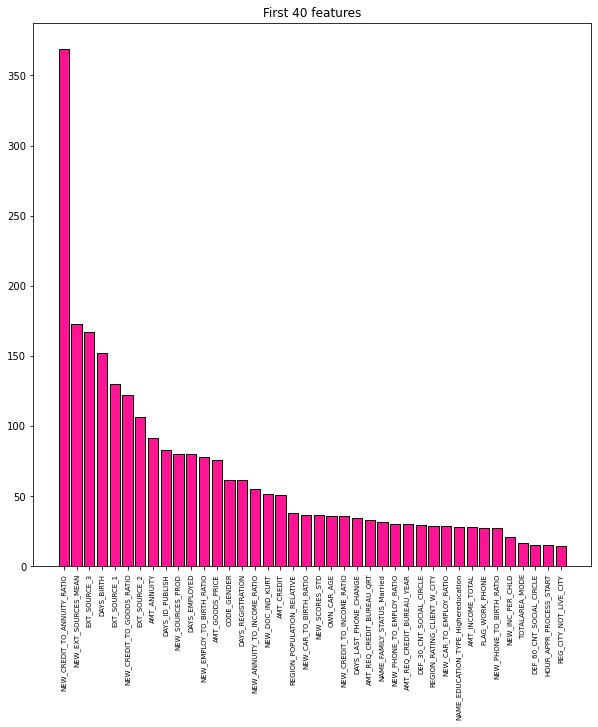

In [365]:
plt.figure(figsize = (10, 10))#.patch.set_facecolor('black');
#plt.cm.get_cmap('nipy_spectral',10)
plt.bar(feat_imp, importance, edgecolor = 'black', facecolor = 'deeppink');
plt.xticks(rotation = 90,fontsize =7);
plt.title('First 40 features')
plt.show()

In [337]:
app_train_test.isnull().sum()

index                                0
SK_ID_CURR                           0
TARGET                           48744
CODE_GENDER                          0
FLAG_OWN_CAR                         0
                                 ...  
WALLSMATERIAL_MODE_Panel             0
WALLSMATERIAL_MODE_Stonebrick        0
WALLSMATERIAL_MODE_Wooden            0
EMERGENCYSTATE_MODE_No               0
EMERGENCYSTATE_MODE_Yes              0
Length: 263, dtype: int64

In [342]:
app_train_test.select_dtypes('int64').apply(pd.Series.nunique)

index                          307509
SK_ID_CURR                     356251
CODE_GENDER                         2
FLAG_OWN_CAR                        2
FLAG_OWN_REALTY                     2
CNT_CHILDREN                       16
DAYS_BIRTH                      17467
DAYS_ID_PUBLISH                  6224
FLAG_MOBIL                          2
FLAG_EMP_PHONE                      2
FLAG_WORK_PHONE                     2
FLAG_CONT_MOBILE                    2
FLAG_PHONE                          2
FLAG_EMAIL                          2
REGION_RATING_CLIENT                3
REGION_RATING_CLIENT_W_CITY         4
HOUR_APPR_PROCESS_START            24
REG_REGION_NOT_LIVE_REGION          2
REG_REGION_NOT_WORK_REGION          2
LIVE_REGION_NOT_WORK_REGION         2
REG_CITY_NOT_LIVE_CITY              2
REG_CITY_NOT_WORK_CITY              2
LIVE_CITY_NOT_WORK_CITY             2
FLAG_DOCUMENT_2                     2
FLAG_DOCUMENT_3                     2
FLAG_DOCUMENT_4                     2
FLAG_DOCUMEN

In [344]:
np.linspace(20, 70, num = 11)

array([20., 25., 30., 35., 40., 45., 50., 55., 60., 65., 70.])

In [357]:
app_train = pd.DataFrame();
app_train['DAYS_BIRTH'] = abs(app_train_test['DAYS_BIRTH']);
app_train['YEARS_BIRTH'] = app_train['DAYS_BIRTH'] / 365;
app_train['YEARS_BINNED'] = pd.cut(app_train['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))

In [358]:
app_train.head(10)

,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,9461,25.920548,"(25.0, 30.0]"
1,16765,45.931507,"(45.0, 50.0]"
2,19046,52.180822,"(50.0, 55.0]"
3,19005,52.068493,"(50.0, 55.0]"
4,19932,54.608219,"(50.0, 55.0]"
5,16941,46.413699,"(45.0, 50.0]"
6,13778,37.747945,"(35.0, 40.0]"
7,18850,51.643836,"(50.0, 55.0]"
8,20099,55.065753,"(55.0, 60.0]"
9,14469,39.641096,"(35.0, 40.0]"


In [364]:
app_train.groupby(by = 'YEARS_BINNED').mean()

,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,
"(20.0, 25.0]",8538.378305,23.392817
"(25.0, 30.0]",10158.553997,27.831655
"(30.0, 35.0]",11856.378412,32.483229
"(35.0, 40.0]",13708.090454,37.556412
"(40.0, 45.0]",15497.596332,42.459168
"(45.0, 50.0]",17323.579317,47.461861
"(50.0, 55.0]",19193.920120,52.586083
"(55.0, 60.0]",20982.126230,57.485277
"(60.0, 65.0]",22779.717434,62.410185


In [8]:
bureau = pd.read_csv(Path(path / 'bureau.csv'))

In [9]:
for i in bureau.columns:
    if bureau[i].dtype != 'object':
        bureau[i] = pd.to_numeric(bureau[i], downcast = 'signed')

In [10]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int32  
 1   SK_ID_BUREAU            int32  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int16  
 5   CREDIT_DAY_OVERDUE      int16  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int8   
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int32  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int16(2), int32(3), int8(1), object(3)
memory usage: 171.9+ MB


In [381]:
app_train_test['SK_ID_CURR'][np.in1d(app_train_test['SK_ID_CURR'].values, bureau['SK_ID_CURR'].values)]

0         100002
1         100003
2         100004
4         100007
5         100008
           ...  
356249    456202
356250    456221
356252    456223
356253    456224
356254    456250
Name: SK_ID_CURR, Length: 305807, dtype: int64

In [392]:
bureau.apply(pd.Series.nunique)

SK_ID_CURR                 305811
SK_ID_BUREAU              1716428
CREDIT_ACTIVE                   4
CREDIT_CURRENCY                 4
DAYS_CREDIT                  2923
CREDIT_DAY_OVERDUE            942
DAYS_CREDIT_ENDDATE         14096
DAYS_ENDDATE_FACT            2917
AMT_CREDIT_MAX_OVERDUE      68251
CNT_CREDIT_PROLONG             10
AMT_CREDIT_SUM             236708
AMT_CREDIT_SUM_DEBT        226537
AMT_CREDIT_SUM_LIMIT        51726
AMT_CREDIT_SUM_OVERDUE       1616
CREDIT_TYPE                    15
DAYS_CREDIT_UPDATE           2982
AMT_ANNUITY                 40321
dtype: int64

In [55]:
def missing_values(df):
    leng = df.shape[0]
    df = df.isnull().sum();
    df_per = np.round(df * 100 / leng, 2);
    miss_values = {'sum of zeros': df, 'percent of zeros': df_per};
    miss_values = pd.DataFrame(miss_values);
    return miss_values

In [12]:
missing_values(bureau).sort_values(by = 'percent of zeros', ascending = False)

,sum of zeros,percent of zeros
AMT_ANNUITY,1226791,71.47
AMT_CREDIT_MAX_OVERDUE,1124488,65.51
DAYS_ENDDATE_FACT,633653,36.92
AMT_CREDIT_SUM_LIMIT,591780,34.48
AMT_CREDIT_SUM_DEBT,257669,15.01
DAYS_CREDIT_ENDDATE,105553,6.15
CREDIT_ACTIVE,0,0.00
CREDIT_CURRENCY,0,0.00
DAYS_CREDIT,0,0.00
CREDIT_DAY_OVERDUE,0,0.00


In [13]:
bureau = bureau.join(app_train_test['TARGET'], how = 'left', on = 'SK_ID_CURR')

In [14]:
bureau.select_dtypes(['int64', 'float64']).corr()['TARGET']

DAYS_CREDIT_ENDDATE       0.000478
DAYS_ENDDATE_FACT        -0.001633
AMT_CREDIT_MAX_OVERDUE   -0.000044
AMT_CREDIT_SUM            0.000918
AMT_CREDIT_SUM_DEBT       0.000823
AMT_CREDIT_SUM_LIMIT      0.000043
AMT_CREDIT_SUM_OVERDUE    0.000319
AMT_ANNUITY               0.002439
TARGET                    1.000000
Name: TARGET, dtype: float64

In [15]:
def le(df):
    cat_feat = df.select_dtypes('object');
    for i in cat_feat:
        if df[i].nunique() <= 2:
            df[i] = LabelEncoder().fit_transfrom(df[i]);
    return df

In [16]:
le(bureau);
bureau = pd.get_dummies(bureau, dummy_na = True)

In [17]:
bureau

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_nan
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,...,0,0,0,0,0,0,0,0,0,0
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,...,0,0,0,0,0,0,0,0,0,0
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.50,NaN,...,0,0,0,0,0,0,0,0,0,0
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.00,NaN,...,0,0,0,0,0,0,0,0,0,0
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,...,0,0,0,0,1,0,0,0,0,0
1716424,100044,5057754,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,...,0,0,0,0,0,0,0,0,0,0
1716425,100044,5057762,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,...,0,0,0,0,0,0,0,0,0,0
1716426,246829,5057770,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
balance = pd.read_csv(Path(path / 'bureau_balance.csv'))

In [39]:
balance = pd.get_dummies(balance, dummy_na = True)

In [111]:
def dec(df):
    for i in df.columns:
        if df[i].dtype == 'float64':
            df[i] = pd.to_numeric(df[i], downcast = 'float')
        elif df[i].dtype != 'object':
            df[i] = pd.to_numeric(df[i], downcast = 'signed');

In [22]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 41 columns):
 #   Column                                                    Dtype  
---  ------                                                    -----  
 0   SK_ID_CURR                                                int32  
 1   SK_ID_BUREAU                                              int32  
 2   DAYS_CREDIT                                               int16  
 3   CREDIT_DAY_OVERDUE                                        int16  
 4   DAYS_CREDIT_ENDDATE                                       float64
 5   DAYS_ENDDATE_FACT                                         float64
 6   AMT_CREDIT_MAX_OVERDUE                                    float64
 7   CNT_CREDIT_PROLONG                                        int8   
 8   AMT_CREDIT_SUM                                            float64
 9   AMT_CREDIT_SUM_DEBT                                       float64
 10  AMT_CREDIT_SUM_LIMIT          

In [21]:
balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 11 columns):
 #   Column          Dtype
---  ------          -----
 0   SK_ID_BUREAU    int32
 1   MONTHS_BALANCE  int8 
 2   STATUS_0        int8 
 3   STATUS_1        int8 
 4   STATUS_2        int8 
 5   STATUS_3        int8 
 6   STATUS_4        int8 
 7   STATUS_5        int8 
 8   STATUS_C        int8 
 9   STATUS_X        int8 
 10  STATUS_nan      int8 
dtypes: int32(1), int8(10)
memory usage: 364.5 MB


In [42]:
balance_agg = {'MONTHS_BALANCE': ['min', 'max', 'size', 'mean']};
for cat in balance.columns:
    if cat != 'MONTHS_BALANCE':
        balance_agg[cat] = ['mean'];
balance = balance.groupby('SK_ID_BUREAU').agg(balance_agg)

In [43]:
balance.columns = [i[0] + '_' + i[1].upper() for i in balance.columns]

In [53]:
bureau = bureau.join(balance, how = 'left', on = 'SK_ID_BUREAU')

In [58]:
del balance

In [57]:
missing_values(bureau).sort_values(by = 'sum of zeros', ascending = False)

,sum of zeros,percent of zeros
AMT_ANNUITY,1226791,71.47
AMT_CREDIT_MAX_OVERDUE,1124488,65.51
STATUS_nan_MEAN,942074,54.89
STATUS_3_MEAN,942074,54.89
MONTHS_BALANCE_MIN,942074,54.89
MONTHS_BALANCE_MAX,942074,54.89
MONTHS_BALANCE_SIZE,942074,54.89
MONTHS_BALANCE_MEAN,942074,54.89
SK_ID_BUREAU_MEAN,942074,54.89
STATUS_0_MEAN,942074,54.89


In [61]:
dec(bureau)

In [65]:
bureau.corr()['TARGET'].sort_values(ascending = False)

TARGET                                                      1.000000
STATUS_3_MEAN                                               0.005354
STATUS_4_MEAN                                               0.004629
STATUS_5_MEAN                                               0.004533
STATUS_2_MEAN                                               0.003843
STATUS_1_MEAN                                               0.003764
MONTHS_BALANCE_SIZE                                         0.002534
AMT_ANNUITY                                                 0.002439
CREDIT_TYPE_Credit card                                     0.001604
STATUS_C_MEAN                                               0.001566
CREDIT_TYPE_Mortgage                                        0.001345
CNT_CREDIT_PROLONG                                          0.001294
CREDIT_CURRENCY_currency 4                                  0.000983
AMT_CREDIT_SUM                                              0.000918
SK_ID_BUREAU_MEAN                 

In [66]:
app_train_test.corr()['TARGET'].sort_values(ascending = False)

TARGET                         1.000000
DAYS_BIRTH                     0.078242
DAYS_EMPLOYED                  0.074957
NEW_CREDIT_TO_GOODS_RATIO      0.069434
REGION_RATING_CLIENT_W_CITY    0.060895
                                 ...   
EXT_SOURCE_1                  -0.155317
EXT_SOURCE_2                  -0.160471
EXT_SOURCE_3                  -0.178926
NEW_SOURCES_PROD              -0.188556
NEW_EXT_SOURCES_MEAN          -0.222054
Name: TARGET, Length: 263, dtype: float64

In [88]:
bureau.drop('SK_ID_BUREAU', inplace = True, axis = 1)

In [89]:
bureau_agg = {'DAYS_CREDIT': ['mean', 'min', 'max', 'var'], 'CREDIT_DAY_OVERDUE': ['mean', 'max'], 
             'CREDIT_DAY_OVERDUE': ['max', 'mean'], 'DAYS_CREDIT_ENDDATE': ['max', 'mean'], 'DAYS_CREDIT_ENDDATE': ['max', 'mean'], 
             'MONTHS_BALANCE_MIN': ['min'], 'MONTHS_BALANCE_MAX': ['max'], 'MONTHS_BALANCE_SIZE': ['mean', 'sum']};
for i  in bureau.columns:
    if i not in bureau_agg.keys():
        bureau_agg[i] = ['mean']

In [90]:
bureau = bureau.groupby('SK_ID_CURR').agg(bureau_agg)

In [94]:
bureau.columns = [i.upper() for i in bureau.columns]

In [100]:
app_train = app_train_test.join(bureau, how = 'left', on = 'SK_ID_CURR')

In [112]:
dec(app_train)

In [113]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356251 entries, 0 to 356254
Columns: 323 entries, index to STATUS_NAN_MEAN_MEAN
dtypes: float32(146), int16(2), int32(2), int8(173)
memory usage: 264.0 MB


In [72]:
def valid_models(lgbm, catboost, X, y):
    folds = KFold(n_splits = 4, shuffle = True, random_state = 42);
    for n, (train, valid) in enumerate(folds.split(X, y)):
        if lgbm:
            model = lgbc(objective = 'binary', max_depth = 20, learning_rate = 0.05, n_estimators = 250,
                        min_split_gain = 0.01, subsample = 0.8, num_leaves = 25);
            model.fit(X.iloc[train], y.iloc[train]);
            print(f'AUC on {n + 1} train iterration - {roc_auc_score(y.iloc[train], model.predict_proba(X.iloc[train])[:, 1])}');
            print(f'AUC on {n + 1} test iterration - {roc_auc_score(y.iloc[valid], model.predict_proba(X.iloc[valid])[:, 1])}');
        elif catboost:
            model = cbc(max_depth = 10, learning_rate = 0.01, iterations = 250, reg_lambda = 0.0735294,
                        subsample = 0.8, max_leaves = 20, logging_level = 'Silent', grow_policy = 'Lossguide');
            model.fit(X.iloc[train], y.iloc[train]);
            print(f'AUC on {n + 1} train iterration - {roc_auc_score(y.iloc[train], model.predict_proba(X.iloc[train])[:, 1])}');
            print(f'AUC on {n + 1} test iterration - {roc_auc_score(y.iloc[valid], model.predict_proba(X.iloc[valid])[:, 1])}');
        else:
            raise ValueError('It is necessary to choose a model.')

In [202]:
valid_models(True, False, X, y)

AUC on 1 train iterration - 0.8222924342760005
AUC on 1 test iterration - 0.7702741491983558
AUC on 2 train iterration - 0.822476915311213
AUC on 2 test iterration - 0.7676967171650291
AUC on 3 train iterration - 0.8223962310033481
AUC on 3 test iterration - 0.7682709058947812
AUC on 4 train iterration - 0.8192610166196272
AUC on 4 test iterration - 0.7740390188263865


In [165]:
valid_models(False, True, X, y)

AUC on 1 train iterration - 0.7411332632096717
AUC on 1 test iterration - 0.7398403656730204
AUC on 2 train iterration - 0.7433361658487819
AUC on 2 test iterration - 0.7338090143032723
AUC on 3 train iterration - 0.7432880747304931
AUC on 3 test iterration - 0.7359400271597295
AUC on 4 train iterration - 0.7414527984793208
AUC on 4 test iterration - 0.742844431522918


In [205]:
folds = KFold(n_splits = 4, shuffle = True, random_state = 42);
params = {'n_estimators': range(30, 150, 30)};#{'max_depth': range(3, 15, 3)} 
gsCV = GridSearchCV(lgbc(objective = 'binary', learning_rate = 0.01, subsample = 0.8), cv = folds, param_grid = params);
gsCV.fit(X, y)

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             estimator=LGBMClassifier(learning_rate=0.01, objective='binary',
                                      subsample=0.8),
             param_grid={'n_estimators': range(30, 150, 30)})

In [207]:
gsCV.best_params_

{'n_estimators': 30}

In [5]:
pd.set_option('display.max_columns', None)

In [8]:
decrease(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356251 entries, 0 to 356254
Columns: 263 entries, index to EMERGENCYSTATE_MODE_Yes
dtypes: float32(86), int16(2), int32(2), int8(40), uint8(133)
memory usage: 182.4 MB


In [9]:
buro_balance = pd.read_csv(Path(path / 'bureau_balance.csv'))

In [10]:
def decrease(df):
    #print(df.info())
    for i in df.columns:
        if df[i].dtype == 'int64':
            df[i] = pd.to_numeric(df[i], downcast = 'signed');
        elif df[i].dtype == 'float64':
            df[i] = pd.to_numeric(df[i], downcast = 'float');
    #print(df.info())
decrease(buro_balance)

In [11]:
cat = [i for i in buro_balance.columns if buro_balance[i].dtype == 'object'];
buro_cat = pd.get_dummies(buro_balance[cat], dummy_na = True);
buro_cat.columns = [i.upper() for i in buro_cat.columns]
buro_balance = pd.concat([buro_balance, buro_cat], axis = 1).drop(cat, axis = 1);
sk_id = buro_balance[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby(['SK_ID_BUREAU']).count();
buro_balance['COUNTS'] = buro_balance['SK_ID_BUREAU'].map(sk_id['MONTHS_BALANCE']);

In [12]:
buro_balance = buro_balance.groupby('SK_ID_BUREAU').mean()

In [13]:
del buro_cat, sk_id

In [16]:
decrease(buro_balance)
buro_balance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817395 entries, 5001709 to 6842888
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   MONTHS_BALANCE  817395 non-null  float32
 1   STATUS_0        817395 non-null  float32
 2   STATUS_1        817395 non-null  float32
 3   STATUS_2        817395 non-null  float32
 4   STATUS_3        817395 non-null  float32
 5   STATUS_4        817395 non-null  float32
 6   STATUS_5        817395 non-null  float32
 7   STATUS_C        817395 non-null  float32
 8   STATUS_X        817395 non-null  float32
 9   STATUS_NAN      817395 non-null  float32
 10  COUNTS          817395 non-null  int8   
dtypes: float32(10), int8(1)
memory usage: 38.2 MB


In [19]:
buro_balance.reset_index(inplace = True)

In [21]:
data.drop('index', axis = 1, inplace = True)

In [26]:
buro_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817395 entries, 0 to 817394
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SK_ID_BUREAU    817395 non-null  int64  
 1   MONTHS_BALANCE  817395 non-null  float32
 2   STATUS_0        817395 non-null  float32
 3   STATUS_1        817395 non-null  float32
 4   STATUS_2        817395 non-null  float32
 5   STATUS_3        817395 non-null  float32
 6   STATUS_4        817395 non-null  float32
 7   STATUS_5        817395 non-null  float32
 8   STATUS_C        817395 non-null  float32
 9   STATUS_X        817395 non-null  float32
 10  STATUS_NAN      817395 non-null  float32
 11  COUNTS          817395 non-null  int8   
dtypes: float32(10), int64(1), int8(1)
memory usage: 38.2 MB


In [27]:
bureau = pd.read_csv(Path(path / 'bureau.csv'))
decrease(bureau)

In [28]:
def encoder(df):
    cat = [df.select_dtypes('object').columns];
    unique = dict(df[cat[0]].nunique())
    for column, uniq in unique.items():
        if uniq == 2:
            categorical = {name: value for value, name in enumerate(df[column].unique())}
            df[column] = df[column].map(categorical)
        else: 
            df_cat = pd.get_dummies(df[column], dummy_na = True);
            df_cat.columns = [column + '_' + str(i).upper() for i in df_cat.columns]
            df = pd.concat([df, df_cat], axis = 1).drop(column, axis = 1);
    return df
bureau = encoder(bureau);

In [30]:
buro_full = buro_balance.merge(right = bureau, how='left', on='SK_ID_BUREAU')

In [33]:
decrease(buro_full)
buro_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817395 entries, 0 to 817394
Data columns (total 51 columns):
 #   Column                                                    Non-Null Count   Dtype  
---  ------                                                    --------------   -----  
 0   SK_ID_BUREAU                                              817395 non-null  int32  
 1   MONTHS_BALANCE                                            817395 non-null  float32
 2   STATUS_0                                                  817395 non-null  float32
 3   STATUS_1                                                  817395 non-null  float32
 4   STATUS_2                                                  817395 non-null  float32
 5   STATUS_3                                                  817395 non-null  float32
 6   STATUS_4                                                  817395 non-null  float32
 7   STATUS_5                                                  817395 non-null  float32
 8   STAT

In [37]:
buro_full = buro_full.groupby(['SK_ID_CURR']).mean();
buro_full.drop('SK_ID_BUREAU', axis = 1, inplace = True);
data = data.merge(right = buro_full, how = 'left', on = 'SK_ID_CURR');
del buro_full, buro_balance, bureau

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356251 entries, 0 to 356250
Columns: 311 entries, SK_ID_CURR to CREDIT_TYPE_NAN
dtypes: float32(134), float64(1), int16(2), int32(1), int8(40), uint8(133)
memory usage: 249.0 MB


In [51]:
credit = pd.read_csv(Path(path / 'credit_card_balance.csv'));
credit = encoder(credit);
decrease(credit);
credit_prev = credit[['SK_ID_PREV', 'SK_ID_CURR']].groupby(['SK_ID_CURR']).count();
credit['SK_ID_PREV'] = credit['SK_ID_CURR'].map(credit_prev['SK_ID_PREV']);
credit_aver = credit.groupby('SK_ID_CURR').mean();

In [53]:
data = data.merge(right = credit_aver, how = 'left', on = 'SK_ID_CURR');
del credit, credit_prev, credit_aver

In [57]:
decrease(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356251 entries, 0 to 356250
Columns: 340 entries, SK_ID_CURR to NAME_CONTRACT_STATUS_NAN
dtypes: float32(164), int16(2), int32(1), int8(40), uint8(133)
memory usage: 287.1 MB


In [60]:
inst = pd.read_csv(Path(path / 'installments_payments.csv'));
decrease(inst);
inst['DAY_DIFF_1'] = inst['DAYS_ENTRY_PAYMENT'] - inst['DAYS_INSTALMENT'];#разница между выплаченым днем и днем, когда нужно было выплатить(относительно дня заявки)
inst['DAY_TIME'] = inst['DAY_DIFF_1'].apply(lambda x: x if x > 0 else 0)#если равно нулю, то вовремя, просрочки нет
inst['DAY_DIFF_2'] = inst['DAYS_INSTALMENT'] - inst['DAYS_ENTRY_PAYMENT'];
inst['AMT_DIFF'] = inst['AMT_PAYMENT'] - inst['AMT_INSTALMENT'];
inst['AMT_PER'] = inst['AMT_PAYMENT'] / inst['AMT_INSTALMENT'];
inst_prev = inst[['SK_ID_PREV', 'SK_ID_CURR']].groupby('SK_ID_CURR').count();
inst['COUNTS_INST'] = inst['SK_ID_CURR'].map(inst_prev['SK_ID_PREV']);
inst_aver = inst.groupby(['SK_ID_CURR']).mean();
decrease(inst_aver);
data = data.merge(right = inst_aver, how = 'left', on = 'SK_ID_CURR');
del inst, inst_aver, inst_prev

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356251 entries, 0 to 356250
Columns: 354 entries, SK_ID_CURR to COUNTS_INST
dtypes: float32(177), float64(1), int16(2), int32(1), int8(40), uint8(133)
memory usage: 307.5 MB


In [62]:
cash = pd.read_csv(Path(path / 'POS_CASH_balance.csv'));
decrease(cash);
cash = encoder(cash);
cash_counts = cash[['SK_ID_CURR', 'MONTHS_BALANCE']].groupby('SK_ID_CURR').count()
cash_counts = cash['SK_ID_CURR'].map(cash_counts['MONTHS_BALANCE']);
cash_counts = pd.DataFrame(cash_counts);
cash_counts.columns = ['MONTH_CASH'];
cash = pd.concat([cash, cash_counts], axis = 1).drop('MONTHS_BALANCE', axis = 1);
cash_aver = cash.groupby('SK_ID_CURR').mean();
data = data.merge(right = cash_aver, on = 'SK_ID_CURR', how = 'left');
del cash, cash_aver, cash_counts
decrease(data)

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356251 entries, 0 to 356250
Columns: 370 entries, SK_ID_CURR to MONTH_CASH
dtypes: float32(194), int16(2), int32(1), int8(40), uint8(133)
memory usage: 327.9 MB


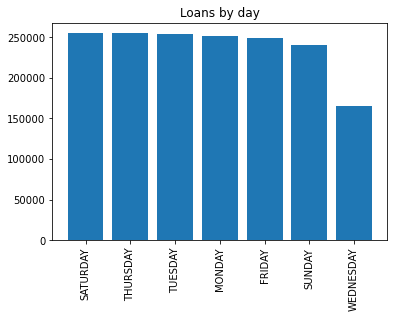

In [65]:
prev_app = pd.read_csv(Path(path / 'previous_application.csv'));
decrease(prev_app);
plt.bar(prev_app['WEEKDAY_APPR_PROCESS_START'].unique(), prev_app['WEEKDAY_APPR_PROCESS_START'].value_counts().values);
plt.xticks(rotation = 90);
plt.title('Loans by day')
plt.show();
prev_app['APP_PER'] = prev_app['AMT_APPLICATION'] / prev_app['AMT_CREDIT'];#отношение запрошенной суммы к полученной
prev_app['APP_PER'] = prev_app['APP_PER'].apply(lambda x: x if x <= 1 else 1)#если отношение меньше единицы, то дали больше, чем требовалось;
prev_app['CR_PER'] = prev_app['AMT_CREDIT'] / prev_app['AMT_APPLICATION'];#отношение данного кредита к запрошенной сумме
prev_app['CR_PER'] = prev_app['CR_PER'].apply(lambda x: x if x <= 1 else 1)#если отношение меньше единицы, то дали меньше, чем требовалось;
days = [i for i in prev_app.columns if i.startswith('DAYS_')];
for i in days:
    prev_app[i].replace(np.nan, 365243.0, inplace = True)
amt = [i for i in prev_app.columns if i.startswith('AMT_')];
amt_dict = {i: ['max', 'min'] for i in amt};
amt.append('SK_ID_CURR');
amt = prev_app[amt].groupby('SK_ID_CURR').agg(amt_dict)
amt.columns = [i[0] + '_' + i[1].upper() for i in amt.columns];
amt.reset_index(inplace = True);
prev_app = prev_app.merge(right = amt, how = 'left', on = 'SK_ID_CURR');
prev_app = encoder(prev_app);
prev_aver = prev_app.groupby('SK_ID_CURR').mean();
prev_aver = prev_aver.drop('SK_ID_PREV', axis = 1);
del prev_app, amt
prev_aver.reset_index(inplace = True);
decrease(prev_aver);
data = data.merge(right = prev_aver, how = 'left', on = 'SK_ID_CURR');
del prev_aver

In [68]:
data.to_csv('Train_test_credit.csv')
data.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356251 entries, 0 to 356250
Columns: 558 entries, SK_ID_CURR to PRODUCT_COMBINATION_NAN
dtypes: float32(382), int16(2), int32(1), int8(40), uint8(133)
memory usage: 583.3 MB


In [ ]:
#data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
#X = data[data['TARGET'].notnull()].drop(['TARGET', 'SK_ID_CURR'], axis = 1);
#y = data[data['TARGET'].notnull()]['TARGET'];
def valid_models_oli(lgbm, catboost, X, y):
    folds = KFold(n_splits = 4, shuffle = True);
    for n, (train, valid) in enumerate(folds.split(X, y)):
        if lgbm:
            model = lgbc(objective = 'binary', max_depth = 30, learning_rate = 0.1, n_estimators = 150,
                        min_split_gain = 0.01, subsample = 0.8, num_leaves = 25);
            model.fit(X.iloc[train], y.iloc[train]);
            print(f'AUC on {n + 1} train iterration - {roc_auc_score(y.iloc[train], model.predict_proba(X.iloc[train])[:, 1])}');
            print(f'AUC on {n + 1} test iterration - {roc_auc_score(y.iloc[valid], model.predict_proba(X.iloc[valid])[:, 1])}');
        elif catboost:
            model = cbc(max_depth = 10, learning_rate = 0.01, iterations = 250, reg_lambda = 0.0735294,
                        subsample = 0.8, max_leaves = 20, logging_level = 'Silent', grow_policy = 'Lossguide');
            model.fit(X.iloc[train], y.iloc[train]);
            print(f'AUC on {n + 1} train iterration - {roc_auc_score(y.iloc[train], model.predict_proba(X.iloc[train])[:, 1])}');
            print(f'AUC on {n + 1} test iterration - {roc_auc_score(y.iloc[valid], model.predict_proba(X.iloc[valid])[:, 1])}');
        else:
            raise ValueError('It is necessary to choose a model.')

In [ ]:
valid_models_oli(True, False, X, y)